In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
def readFile(filename):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    print("=====Total Personal Income File=====")
    return df_1

In [5]:
SC_HPI = readFile("SC_HousePriceIndex.csv")

File read into dataframe.
(39, 1)
=====Total Personal Income File=====


In [6]:
SC_HPI.rename(columns={'SC_House Price Index': 'SC_HousePriceIndex'}, inplace=True)

In [7]:
SC_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [8]:
SC_HPI.head()

,SC_HousePriceIndex
1977-01-01,79.8525
1978-01-01,86.6950
1979-01-01,96.6175
1980-01-01,104.5200
1981-01-01,114.8100


In [9]:
SC_HPI.SC_HousePriceIndex.describe()

count     39.000000
mean     211.273782
std       83.611536
min       79.852500
25%      140.783750
50%      193.940000
75%      301.566250
max      340.542500
Name: SC_HousePriceIndex, dtype: float64

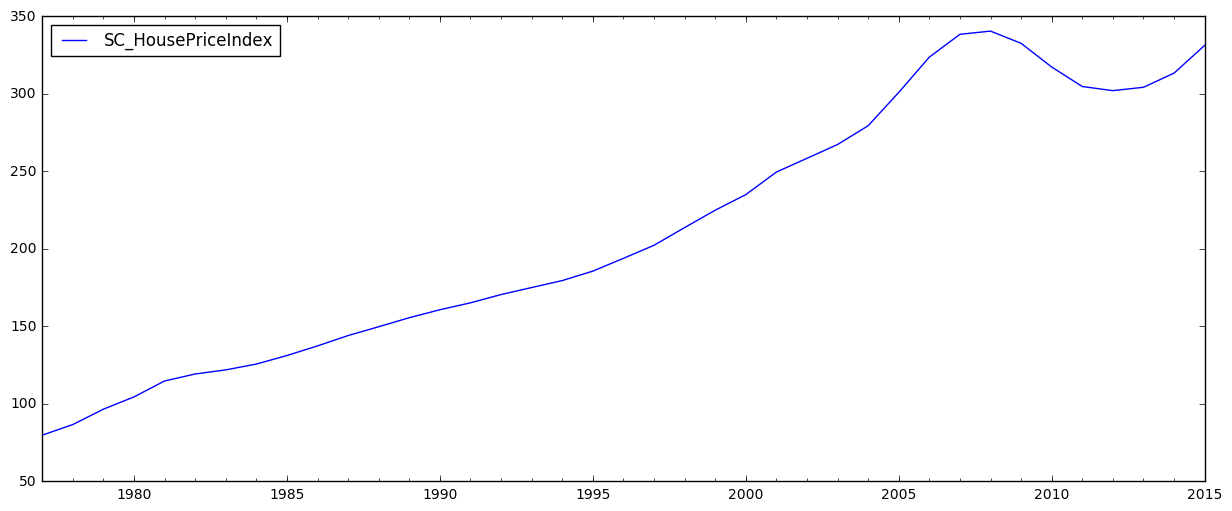

In [10]:
SC_HPI.plot(figsize=(15,6))
plt.show()

There is an overall increasing trend in the data except we can we dip during crisis time in year 2007.

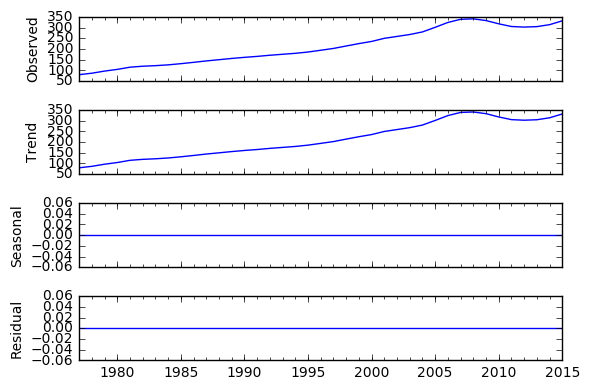

In [11]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(SC_HPI, model='additive')
fig = decomposition.plot()
plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [12]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [13]:
meanVarianceCheck(SC_HPI)

('mean1=137.092500, mean2=281.746000',
 'variance1=966.452063, variance2=2170.506427')

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

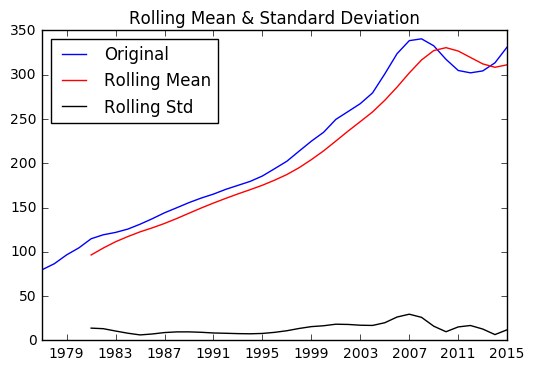

Results of Dickey-Fuller Test:
Test Statistic                 -0.031724
p-value                         0.955829
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64


In [15]:
test_stationarity(SC_HPI.SC_HousePriceIndex)

# Estimating & Eliminating Trend

In [16]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

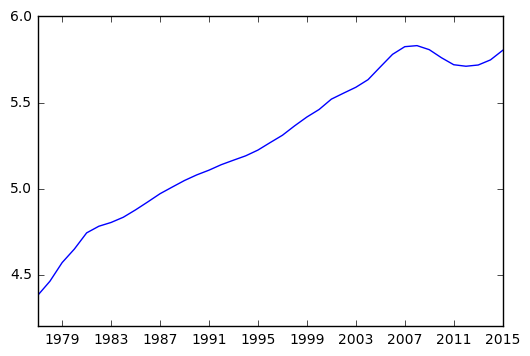

In [17]:
ts_log = logTransform(SC_HPI)

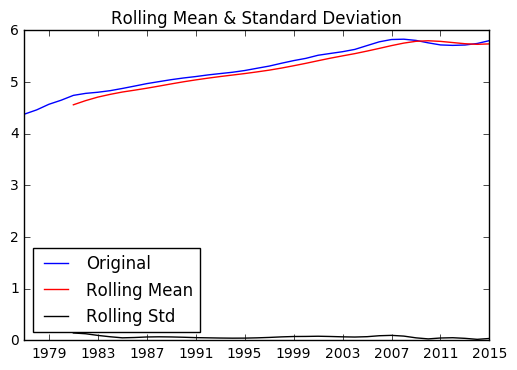

Results of Dickey-Fuller Test:
Test Statistic                 -1.014417
p-value                         0.747970
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64


In [18]:
test_stationarity(ts_log.SC_HousePriceIndex)

In [19]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

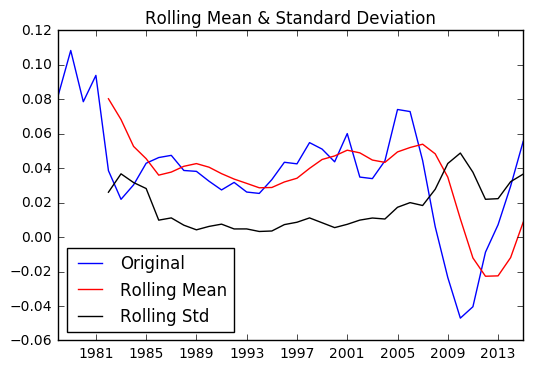

Results of Dickey-Fuller Test:
Test Statistic                 -3.387333
p-value                         0.011398
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64


In [20]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.SC_HousePriceIndex)

In [21]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

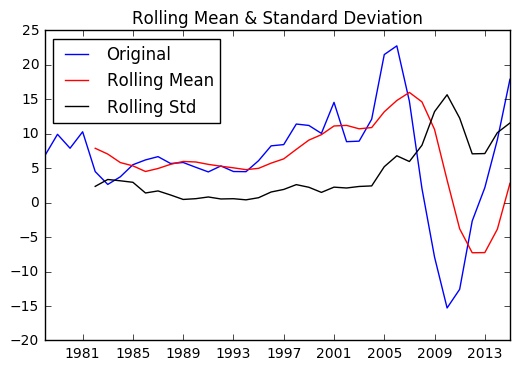

Results of Dickey-Fuller Test:
Test Statistic                 -3.960003
p-value                         0.001635
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64


In [22]:
ts_first_diff = firstDifference(SC_HPI)
test_stationarity(ts_first_diff.SC_HousePriceIndex)

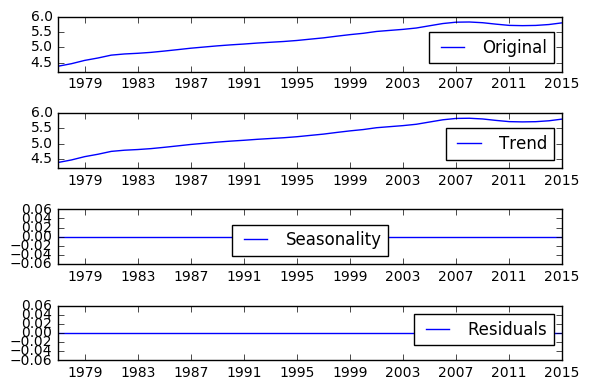

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

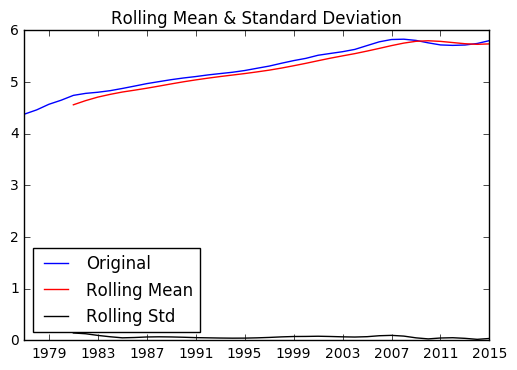

Results of Dickey-Fuller Test:
Test Statistic                 -1.014417
p-value                         0.747970
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
dtype: float64


In [24]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.SC_HousePriceIndex)

In [84]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

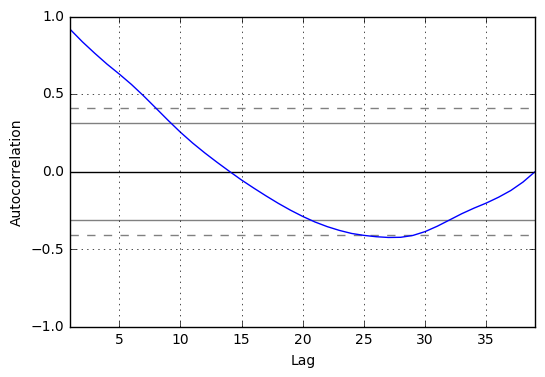

In [85]:
autocorrelation_plot(ts_log)
plt.show()

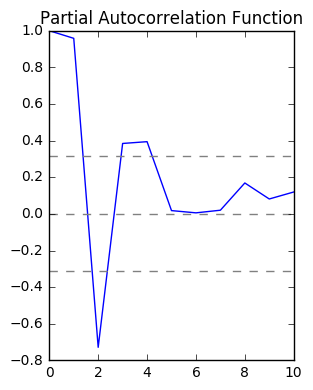

In [86]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [87]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [88]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [89]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                       5.076774
ar.L1.SC_HousePriceIndex    1.925563
ar.L2.SC_HousePriceIndex   -0.928593
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     SC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                  93.843
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 26 Apr 2017   AIC                           -179.686
Time:                        22:42:43   BIC                           -173.032
Sample:                    01-01-1977   HQIC                          -177.299
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.0768

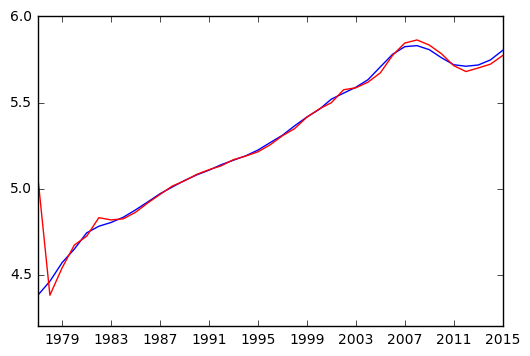

In [90]:
model_AR = AR_Model(ts_log)

In [95]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 2))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 2))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       5.264391
ma.L1.SC_HousePriceIndex    1.933674
ma.L2.SC_HousePriceIndex    1.000000
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     SC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 2)   Log Likelihood                  23.974
Method:                       css-mle   S.D. of innovations              0.117
Date:                Wed, 26 Apr 2017   AIC                            -39.947
Time:                        22:43:19   BIC                            -33.293
Sample:                    01-01-1977   HQIC                           -37.560
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.2644

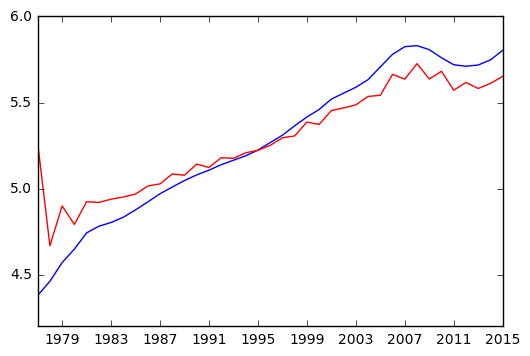

In [96]:
model_MA = MA_Model(ts_log)

In [102]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(2,0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                       5.124122
ar.L1.SC_HousePriceIndex    1.893985
ar.L2.SC_HousePriceIndex   -0.897470
ma.L1.SC_HousePriceIndex    0.221416
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     SC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 1)   Log Likelihood                  94.939
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 26 Apr 2017   AIC                           -179.878
Time:                        22:44:22   BIC                           -171.560
Sample:                    01-01-1977   HQIC                          -176.894
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

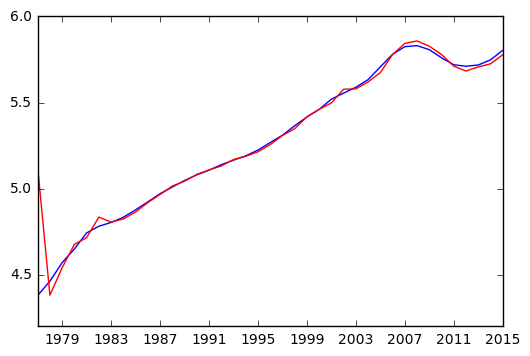

In [103]:
model_Combined = Combined_Model(ts_log)

In [104]:
aic_metric

,AIC,Modelname
0,-179.686171,"ARIMA(ts, order=(2, 0, 0))"
0,-39.947358,"ARIMA(ts, order=(0, 0, 2))"
0,-167.875056,"ARIMA(ts, order=(2, 0, 4))"
0,-179.878145,"ARIMA(ts, order=(2, 0, 1))"


In [105]:
aic_dict

{'ARIMA(ts, order=(0, 0, 2))': -39.947358367313655,
 'ARIMA(ts, order=(2, 0, 0))': -179.68617063298225,
 'ARIMA(ts, order=(2, 0, 1))': -179.87814459375383,
 'ARIMA(ts, order=(2, 0, 4))': -167.87505592073163}

In [106]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 0, 1))


In [107]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output 

In [109]:
output_forecast = forecast(model_AR,5)

[ 348.12161261  363.60180793  377.65378457  390.17356095  401.08795246]


In [55]:
#AR model
#model = ARIMA(ts_log, order=(2, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
#print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.aic)

#MA model
#model = ARIMA(ts_log, order=(0, 1, 1))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')


#Combined model
#model = ARIMA(ts_log, order=(3, 1, 1))  
#results_ARIMA = model.fit(disp=-1) 
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')